In [410]:
import pandas as pd
## Cell computation timer
%load_ext autotime
import numpy as np

import h5py
filename = r"C:\Users\Home\Documents\Second Spectrum Everton Project\HDF5 files\1059990.h5"

key='result1'
df=pd.read_hdf(filename,key)

df.Team_Name=df.Team_Name.fillna('BALL')
df.columns = df.columns.str.replace(' ', '')
tracking=df
tracking['Team_Name']=tracking['Team_Name'].astype(str)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 32.4 s


In [ ]:
###### In {Possession: Southampton} ############

### Subsetting data for when team: Southampton is in possession ###
SOU_team = 1

##bringing the scale with 108x65 coordinates
tracking['x1']=tracking['x']+(min(NO_BALL_tracking['x'])*-1)
tracking['y1']=tracking['y']+(min(NO_BALL_tracking['y'])*-1)
tracking['Live']=np.where((tracking['x']==0) & (tracking['y']==0) & 
                          (tracking['Team_Name'] == 'BALL'),'Alive','Dead')
tracking['ball_x']=np.where((tracking['Team_Name'] == 'BALL') & (tracking['playerId']==0),tracking['x'],np.nan)
tracking['ball_y']=np.where((tracking['Team_Name'] == 'BALL') & (tracking['playerId']==0),tracking['y'],np.nan)
tracking['ball_y'].fillna(method='ffill')
tracking['ball_x'].fillna(method='ffill')
tracking=tracking.sort_values(['frameIdx','playerId'], ascending=[True,True])


In [205]:
## there is a ball_status column within the tracking data with 
## two options ["live", "True/False"] - we keep the "Alive" frames only

alive_tracking = tracking[tracking['live'] == True].reset_index(drop=True)

## check first row in event data to determine which team FCN was, assign the result
## to the 'SOU_team' variable

team_tracking = tracking[tracking['Team_Name'] != ' NEW '].reset_index(drop=True)



time: 12.9 s


In [207]:
#In-Possession:
IP_tracking = tracking[tracking['In_Possession'] == 'IP'].reset_index(drop=True)
OOP_tracking = tracking[tracking['In_Possession'] == 'OOP'].reset_index(drop=True)


time: 12.5 s


In [209]:
### Make a List of All Frames that 'in-play' and FCN in Possession
## create a list of the frameIDs that are in-play
team_frames = list(set(team_tracking['frameIdx']))

## we will measure every 1/5 second of tracking data to see if 
## there is a low-block during that frame. This reduces the computational
## load of the analysis. The tracking data has 25 frames of data per second
## Let's take every 5th frame of the all_alive_frames
team_frames = team_frames[0::5]

## we then remove all frames where opposition were in possession
team_tracking1 = team_tracking[team_tracking['frameIdx'].isin(team_frames)].reset_index(drop=True)
all_out_possession_frames = team_tracking[team_tracking['lastTouch'] == 'home'].reset_index(drop=True).drop_duplicates()['frameIdx'].reset_index(drop=True)
#team_tracking1.to_csv(r'C:\Users\Home\Documents\check1.csv')

time: 5.68 s


In [317]:
def animate_shot(starting_frame, ending_frame, SOU_team):

    ##### Animate the Section to Understand 
    from matplotlib import animation
    from pitch import Pitch

    frames_to_animate = list(range(starting_frame, ending_frame))

    pitch = Pitch(pitch_type='statsbomb',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
                  pitch_width=108,pitch_length=65,stripe=True,goal_type='line',axis=True,label=True)
    fig, ax = pitch.draw()

    ball, = ax.plot([], [], 'ko', ms=8,markerfacecolor='yellow',zorder=3)
    team_0, = ax.plot([], [], 'ko', ms=12,markerfacecolor='blue') #red/maroon
    team_1, = ax.plot([], [], 'ko', ms=12,markerfacecolor='red') #purple
    #def_centroid, = ax.plot([], [], 'ko', ms=10,markerfacecolor='green') #purple
    #att_centroid, = ax.plot([], [], 'ko', ms=10,markerfacecolor='purple') #purple

    # initialization function: plot the background of each frame
    def init():
        ball.set_data([], [])
        team_0.set_data([], [])
        team_1.set_data([], [])
        #def_centroid.set_data([], [])
        #att_centroid.set_data([], [])


        return ball, team_0, team_1#, def_centroid, att_centroid

    # animation function of dataframes' list
    def animate(i):

        frame_ = tracking[tracking['frameIdx'] == frames_to_animate[i]]
        ball_ = frame_[frame_['Team_Name'] == 'BALL'].reset_index()
        team0_ = frame_[frame_['Team_Name'] == ' NEW '].reset_index()
        #team0_ = team0_[team0_['Team_Name'] == 'NEW'].reset_index()
        team1_ = frame_[frame_['Team_Name'] == 'SOU '].reset_index()

        # set the ball data with the x and y positions for the ith frame
        ball.set_data(ball_.iloc[0]['x1'], ball_.iloc[0]['y1'])

        # set the player data using the frame id
        team_0.set_data(team0_.x1,team0_.y1)
        team_1.set_data(team1_.x1,team1_.y1)


        ax.set_title(str(frames_to_animate[i]))

        #plt.axvline(x=-((tracking_meta['pitch_x'] * 100)/2) + 1500, color = "red")
        #plt.axvline(x=-((tracking_meta['pitch_x'] * 100)/2) + 3000, color = "red")


        #plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) -1500, color = "red")
       # plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) - 3000, color = "red")



        return ball, team_0, team_1
    # call the animator, animate every 300 ms
    # note that its hard to get the ffmpeg requirements right. I installed from conda-forge: see the conda.yml file
    anim = animation.FuncAnimation(fig, animate, frames=len(frames_to_animate), init_func=init, interval=25, blit=True)
    # anim.save('demo.mp4',dpi=72, fps=6,extra_args=['-vcodec', 'libx264'])
    return(anim)

time: 3.03 ms


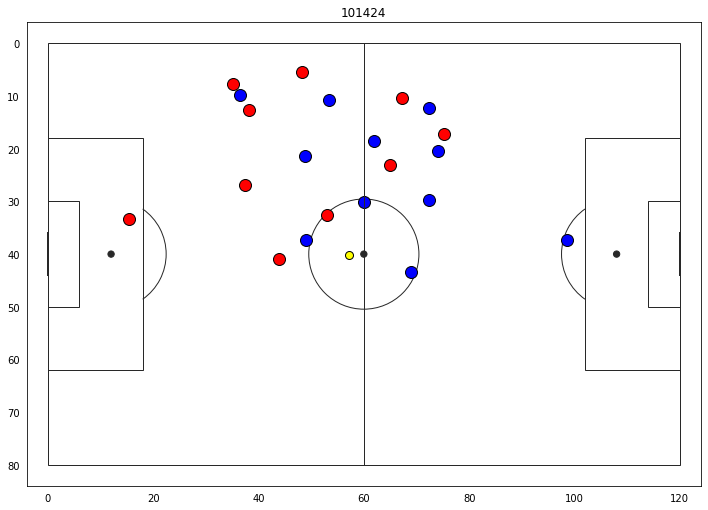

time: 52.6 s


In [319]:
# gap = 25
from IPython.display import HTML
HTML(animate_shot(101425,101425, 1).to_html5_video()) 

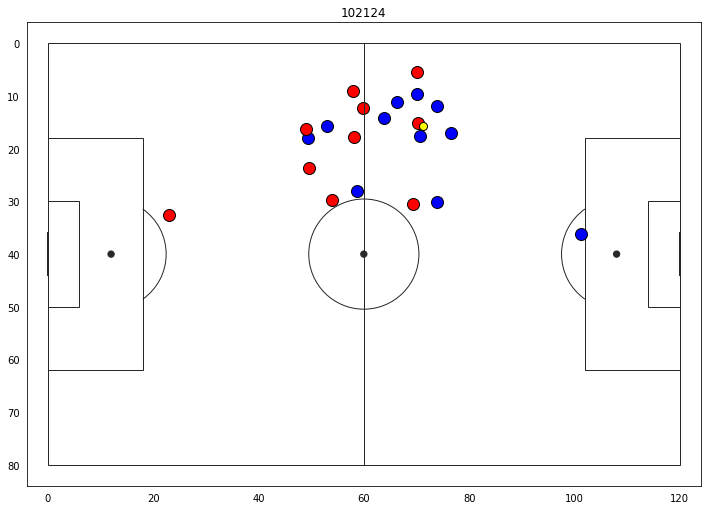

time: 23.4 s


In [335]:
#101400
HTML(animate_shot(10200,102125, 1).to_html5_video()) 

In [254]:
tracking.Team_Name.unique()

array([' NEW ', 'BALL', 'SOU '], dtype=object)

time: 340 ms


In [409]:
mask = (tracking['frameIdx'] > 104000) & (tracking['frameIdx'] <= 104200)
df1 = tracking.loc[mask]
df.playerId.value_counts()

67089     148811
170137    148811
84939     148811
213482    148811
58376     148811
57145     148811
171771    148811
38290     148811
88900     148811
179018    148811
40146     148811
00000     148811
101148    148811
132015    148811
101178    148811
50232     148811
104547    148811
128198    132370
153127    123130
20452     121210
109528    112810
56983      97090
180974     51721
431131     41500
116543     36001
200439     27601
180135     25681
220598     16441
Name: playerId, dtype: int64

time: 2.25 s


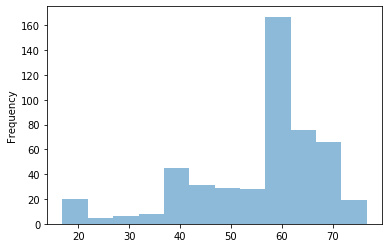

time: 856 ms


In [398]:
df1.reset_index(drop=True)
ball_check=df1[df1['Team_Name']=='BALL']
x=ball_check['x1']
ax = x.plot.hist(bins=12, alpha=0.5)

 0.00    637
-7.55      3
 8.81      2
 9.01      1
 8.91      1
        ... 
 9.29      1
 9.07      1
-0.38      1
 4.36      1
 3.45      1
Name: x, Length: 61, dtype: int64

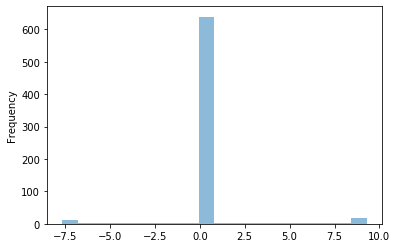

time: 890 ms


In [347]:
x=ball_check['x']
ax = x.plot.hist(bins=20, alpha=0.5)
ball_check['x'].value_counts() 

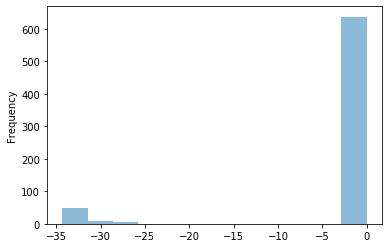

time: 875 ms


In [344]:
y=ball_check['y']
ax = y.plot.hist(bins=12, alpha=0.5)

In [297]:
df1.to_csv(r'C:\Users\Home\Documents\check2.csv')

time: 14 ms
